In [1]:
import healpy as hp
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
from pygdsm import GlobalSkyModel2016, GlobalSkyModel

import timeit, functools

import src.beam_functions as BF
import src.spherical_harmonics as SH
import src.forward_model as FM
import src.sky_models as SM
import src.map_making as MM

RS = SH.RealSphericalHarmonics()

In [2]:
def make_map_trivial_obs(d, noise_covar, lmod, nside, beam_use):
    """
    Calculate the inversion matrix W and apply it to the data, assuming the
    trivial observation strategy.
    """
    

In [3]:
def forward_model_trivial_obs(fg_alm, nside, beam_use):
    """
    Generate noisy timeseries data and its noise covariance given a set of real
    sky alm. The trivial observation strategy is used without binning.
    Returns: (d, N)
    """
    lmax = SH.RealSphericalHarmonics().get_lm(idx=len(fg_alm)-1)[0]
    npix = hp.nside2npix(nside)

    # Calculate total observation matrix.
    mat_A_narrowbeam = FM.calc_observation_matrix_all_pix(
        nside=nside, 
        lmax=lmax, 
        Ntau=npix, 
        Nt=npix,
        beam_use=beam_use
    )
    # Generate data.
    data_narrowbeam = mat_A_narrowbeam @ fg_alm
    noisy_data_narrowbeam, noise_cov_narrowbeam = SM.add_noise(
        data_narrowbeam, 
        dnu=1, 
        Ntau=npix, 
        t_int=1e4*npix
    )
    return noisy_data_narrowbeam, noise_cov_narrowbeam


In [4]:
# Time how long it takes to generate new foreground spherical harmonic maps.
def gen_fg_alm(lmax):
    nside = None
    fg_alm = SM.foreground_gdsm_alm(nu=60, lmax=lmax, nside=nside)
    return fg_alm

In [ ]:
def time_gen_fg_alm():
    lmax_arr = np.logspace(1, 3, 4)
    times = []
    for lmax in lmax_arr:
        f = functools.partial(gen_fg_alm, lmax)
        times.append(timeit.timeit(stmt=f, number=2))
    return times

times = time_gen_fg_alm()

Text(0, 0.5, 'time generating fg alm from full PyGDSM [sec]')

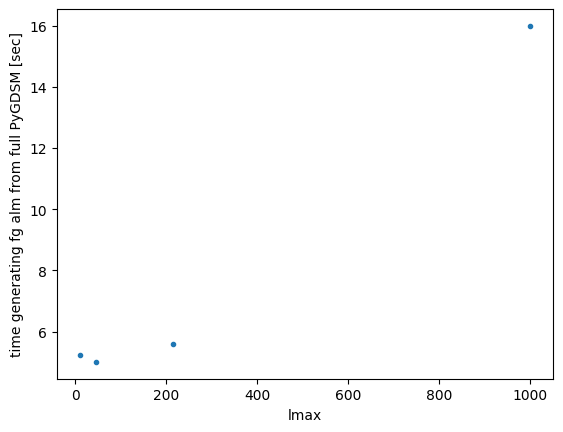

In [15]:
plt.plot(np.logspace(1, 3, 4), times, '.')
plt.xlabel("lmax")
plt.ylabel("time generating fg alm from full PyGDSM [sec]")

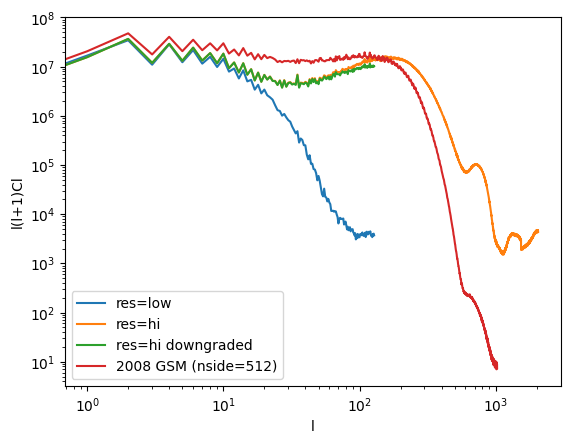

In [2]:
lmax_lo = 64*2
lmax_hi = 1024*2
lmax_2008 = 512*2
map_lo = GlobalSkyModel2016(resolution='low').generate(60)
map_hi = GlobalSkyModel2016(resolution='hi').generate(60)
map_dn = hp.pixelfunc.ud_grade(map_hi, nside_out=64)
map_2008 = GlobalSkyModel().generate(60)
cl_lo = hp.sphtfunc.anafast(map_lo, lmax=lmax_lo)
cl_hi = hp.sphtfunc.anafast(map_hi, lmax=lmax_hi)
cl_dn = hp.sphtfunc.anafast(map_dn, lmax=lmax_lo)
cl_2008 = hp.sphtfunc.anafast(map_2008, lmax=lmax_2008)
norm_lo = np.array([l*(l+1) for l in range(lmax_lo+1)])
norm_hi = np.array([l*(l+1) for l in range(lmax_hi+1)])
norm_2008 = np.array([l*(l+1) for l in range(lmax_2008+1)])

plt.loglog(norm_lo*cl_lo, label='res=low')
plt.loglog(norm_hi*cl_hi, label='res=hi')
plt.loglog(norm_lo*cl_dn, label="res=hi downgraded")
plt.loglog(norm_2008*cl_2008, label="2008 GSM (nside=512)")
plt.xlabel('l')
plt.ylabel('l(l+1)Cl')
plt.legend()
plt.show()

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:122: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


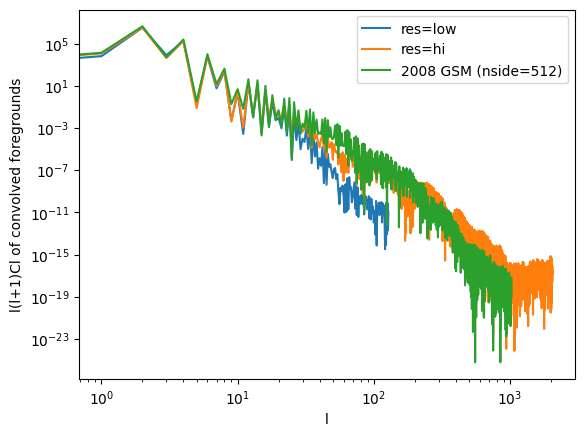

In [3]:
idx_2008 = SH.RealSphericalHarmonics().get_idx(l=lmax_2008, m=lmax_2008) + 1
idx_lo = SH.RealSphericalHarmonics().get_idx(l=lmax_lo, m=lmax_lo) + 1
'''
cosbeam_mat_hi = BF.calc_blm(nside=1024, lmax=lmax_hi, beam_use=lambda x: BF.beam_cos(x, 0.8)
np.save("saves/tight_cosbeam_alm_nside1024", cosbeam_mat_hi)
'''
cosbeam_blm_hi = np.load("saves/tight_cosbeam_alm_nside1024.npy")

cosbeam_blm_lo = cosbeam_blm_hi[:idx_lo]
cosbeam_blm_2008 = cosbeam_blm_hi[:idx_2008]

# Convolve the different foregrounds with the beam.
# First convert maps to real alm.
alm_real_lo = RS.complex2RealALM(hp.map2alm(map_lo, lmax=lmax_lo))
alm_real_hi = RS.complex2RealALM(hp.map2alm(map_hi, lmax=lmax_hi))
alm_real_2008 = RS.complex2RealALM(hp.map2alm(map_2008, lmax=lmax_2008))

# Then convolve with the beam.
alm_real_conv_lo = cosbeam_blm_lo*alm_real_lo
alm_real_conv_hi = cosbeam_blm_hi*alm_real_hi
alm_real_conv_2008 = cosbeam_blm_2008*alm_real_2008

# Finally convert maps back to complex alm.
alm_conv_lo = RS.real2ComplexALM(alm_real_conv_lo)
alm_conv_hi = RS.real2ComplexALM(alm_real_conv_hi)
alm_conv_2008 = RS.real2ComplexALM(alm_real_conv_2008)

# Take the power spectrum of the convolved beams.
cl_conv_lo = hp.alm2cl(alm_conv_lo, lmax=lmax_lo)
cl_conv_hi = hp.alm2cl(alm_conv_hi, lmax=lmax_hi)
cl_conv_2008 = hp.alm2cl(alm_conv_2008, lmax=lmax_2008)

plt.loglog(norm_lo*cl_conv_lo, label='res=low')
plt.loglog(norm_hi*cl_conv_hi, label='res=hi')
plt.loglog(norm_2008*cl_conv_2008, label="2008 GSM (nside=512)")
plt.xlabel('l')
plt.ylabel('l(l+1)Cl of convolved foregrounds')
plt.legend()
plt.show()

In [2]:
#takes 44 min
'''
y_soupahi = SH.calc_spherical_harmonic_matrix(nside=64, lmax=2*64)
#takes 44 sec
np.save("saves/ylm_mat_nside64_lmax128", y_soupahi)
'''
y_soupahi = np.load("saves/ylm_mat_nside64_lmax128.npy")

49152 8385


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:122: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


In [5]:
#takes 10 min
nside=64
'''y_hi = SH.calc_spherical_harmonic_matrix(nside=nside, lmax=nside)
np.save("saves/ylm_mat_nside64_lmax64", y_hi)'''

y_hi = np.load("saves/ylm_mat_nside64_lmax64.npy")
#takes 1 min
y_mats = [SH.calc_spherical_harmonic_matrix(nside=nside, lmax=l) for l in [2,  4,  8, 16, 32]]
y_mats.append(y_hi)

49152 2145


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:122: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


49152 6
49152 15
49152 45
49152 153
49152 561


In [8]:
#takes 15 sec
nside=64
cosbeam_blm_hi = BF.calc_blm(nside=nside, lmax=2*nside, beam_use=lambda x: BF.beam_cos(x, 0.8))
cosbeam_blms   = [BF.calc_blm(nside=nside, lmax=l, beam_use=lambda x: BF.beam_cos(x, 0.8)) for l in [2,  4,  8, 16, 32, 64]]
fg_alm_hi = SM.foreground_gdsm_galcut_alm(nu=60, lmax=128, nside=nside)
fg_alms   = [SM.foreground_gdsm_galcut_alm(nu=60, lmax=l, nside=nside) for l in [2,  4,  8, 16, 32, 64]]

In [11]:
cosbeam_soupahi = BF.calc_beam_matrix(nside=nside, lmax=128, beam_use=lambda x: BF.beam_cos(x, 0.8))
cosbeam = BF.calc_beam_matrix(nside=nside, lmax=64, beam_use=lambda x: BF.beam_cos(x, 0.8))

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:122: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


In [12]:
d1 = y_soupahi @ (cosbeam_soupahi@fg_alm_hi)
d2 = []
for i in range(len(y_mats)):
    d2.append(y_mats[i] @ (cosbeam[:len(fg_alms[i]), :len(fg_alms[i])] @ fg_alms[i]))

In [13]:
delta = [d1 - d2_term for d2_term in d2]
delta_rms = [np.sqrt(np.mean((d)**2)) for d in delta]

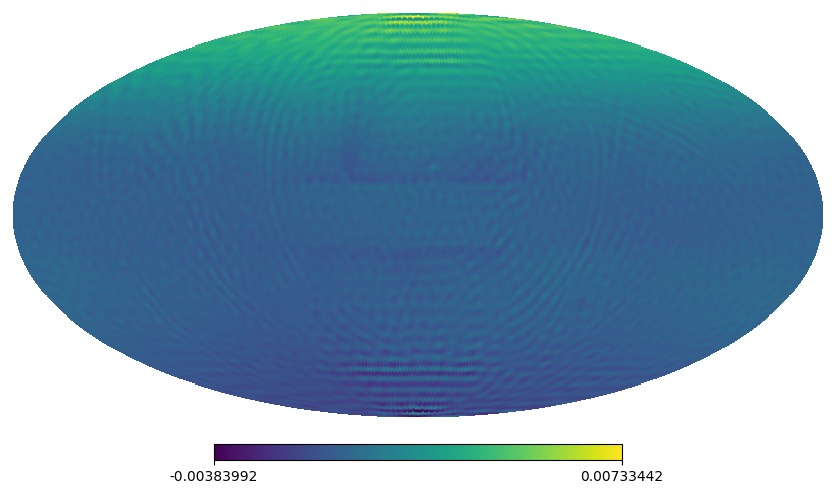

In [14]:
hp.mollview(delta[-1], title='')

Text(0, 0.5, 'RMS temperature residuals from $l_{max}=128$')

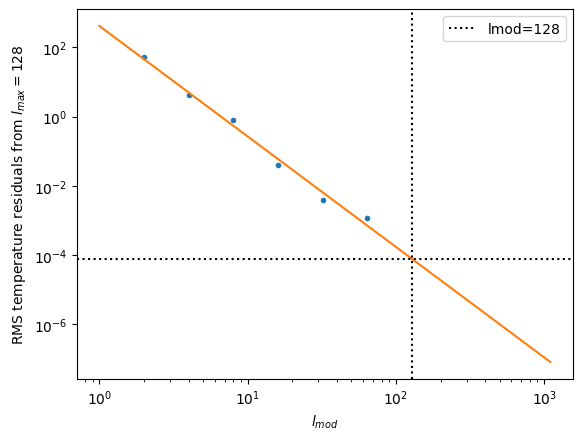

In [26]:
res = linregress(x=np.log([2,  4,  8, 16, 32, 64]), y=np.log(delta_rms))
fitfunc = lambda xx: res.slope*xx + res.intercept

xx = np.linspace(0,7)

plt.loglog([2,  4,  8, 16, 32, 64], delta_rms, '.')
plt.loglog(np.exp(xx), np.exp(fitfunc(xx)))
plt.axvline(128, linestyle=':', color='k', label="lmod=128")
plt.axhline(np.exp(fitfunc(np.log(128))), linestyle=':', color='k')
plt.legend()
plt.xlabel(r'$l_{mod}$')
plt.ylabel('RMS temperature residuals from $l_{max}=128$')

In [5]:
# Time how long it takes to forward model given maps with different lmax, and 
# different nside. Note that the nside matters in the product PY, and is
# otherwise not relevant. A potential thing to look into is if there's an 
# analytic solution.
lmax_arr = [10]#np.int32(np.logspace(1, 3, 4))
fg_alm_arr = [gen_fg_alm(lmax=lmax) for lmax in lmax_arr]
print(f"testing lmax={lmax_arr}")


testing lmax=[10]


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:122: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


In [28]:
d= forward_model_trivial_obs(fg_alm=gen_fg_alm(lmax=16), nside=64, beam_use=BF.beam_cos)

49152 153
Time taken to calculate:
G : 46.360187292099
Y : 53.87378478050232
B : 0.7745740413665771


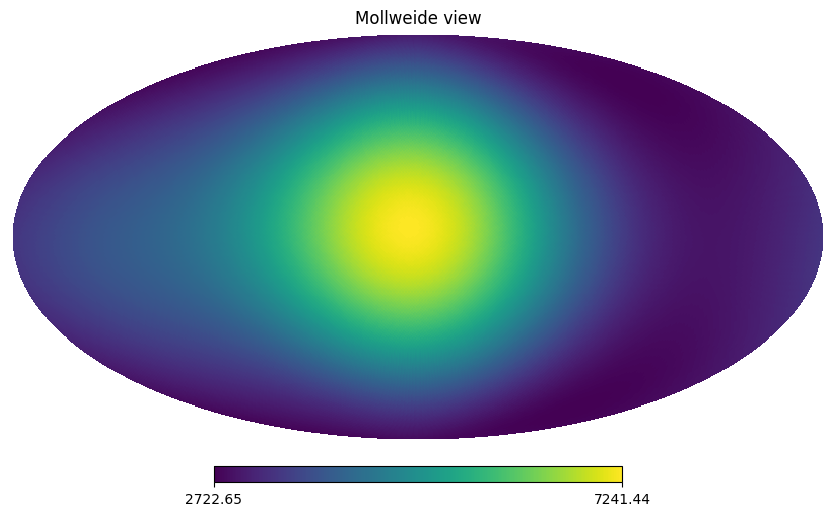

In [6]:
hp.mollview(d[0])

In [49]:
def time_forward_model_trivial_obs():
    nside_arr = [20]
    times = []
    full_time_arr = []
    for nside in nside_arr:
        for fg_alm in fg_alm_arr:
            f = functools.partial(forward_model_trivial_obs, fg_alm, nside, BF.beam_cos)
            times.append(timeit.timeit(stmt=f, number=1))
        full_time_arr.append(times)
    return full_time_arr

times = time_forward_model_trivial_obs()

4800 66


/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:122: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


4800 1128
4800 23436

is this really what you want?


is this really what you want?


is this really what you want?


is this really what you want?



ValueError: scale < 0

In [ ]:
d, mat_N = forward_model_trivial_obs()

In [6]:
nside=32
npix = hp.nside2npix(nside)
narrow_cosbeam = lambda theta: BF.beam_cos(theta, theta0=0.8)
y_fid = np.load('saves/ylm_mat_nside32_lmax64.npy')
b_fid = BF.calc_beam_matrix(nside=nside, lmax=2*nside, beam_use=narrow_cosbeam)
a_fid, map_fid = SM.foreground_gdsm_alm(nu=60, lmax=2*nside, nside=nside, map=True)
d_fid = y_fid@b_fid@a_fid

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:122: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


In [4]:
noise_mat_zero = np.diag(np.ones(shape=len(d_fid)))  # In the noise-free case, the noise covariance matrix is the identity matrix.
lmods = [4, 8, 16, 24, 32, 40, 48, 56, 64]
for lmod in [4, 8, 16, 24, 32, 40, 48, 56, 64]:
    y_mod = SH.calc_spherical_harmonic_matrix(nside=nside, lmax=lmod)
    b_mod = BF.calc_beam_matrix(nside=nside, lmax=lmod, beam_use=narrow_cosbeam)
    w_mat = MM.calc_ml_estimator_matrix(mat_A=y_mod@b_mod, mat_N=noise_mat_zero)
    a_ml  = w_mat@d_fid
    np.save(f"saves/estimated_alm_lmod{lmod}", a_ml)


12288 45
12288 325
12288 861
12288 1653


In [6]:
d_noisy_1e3, noise_mat_1e3 = SM.add_noise(d_fid, dnu=1, Ntau=npix, t_int=1e3)
d_noisy_1e4, noise_mat_1e4 = SM.add_noise(d_fid, dnu=1, Ntau=npix, t_int=1e4)
d_noisy_1e6, noise_mat_1e6 = SM.add_noise(d_fid, dnu=1, Ntau=npix, t_int=1e6)
y_mod_full = np.load('saves/ylm_mat_nside32_lmax64.npy')
for lmod in [4, 8, 16, 24, 32, 40, 48, 56, 64]:
    b_mod = BF.calc_beam_matrix(nside=nside, lmax=lmod, beam_use=narrow_cosbeam)
    y_mod = y_mod_full[:,:len(b_mod)]
    w_mat_1e3 = MM.calc_ml_estimator_matrix(mat_A=y_mod@b_mod, mat_N=noise_mat_1e3)
    w_mat_1e4 = MM.calc_ml_estimator_matrix(mat_A=y_mod@b_mod, mat_N=noise_mat_1e4)
    w_mat_1e6 = MM.calc_ml_estimator_matrix(mat_A=y_mod@b_mod, mat_N=noise_mat_1e6)
    a_1e3 = w_mat_1e3@d_noisy_1e3
    a_1e4 = w_mat_1e4@d_noisy_1e4
    a_1e6 = w_mat_1e6@d_noisy_1e6
    np.save(f"saves/estimated_alm_lmod{lmod}_noise1e3", a_1e3)
    np.save(f"saves/estimated_alm_lmod{lmod}_noise1e4", a_1e4)
    np.save(f"saves/estimated_alm_lmod{lmod}_noise1e6", a_1e6)

/Users/yordani/Documents/boosted_compass/matrix-observer/src/spherical_harmonics.py:122: ComplexWarning: Casting complex values to real discards the imaginary part
  almr[idxr_p] = almc[idxc]


In [3]:
cutoffs = []
cutoffs_l = []
for lmod in lmods:
    cutoffs.append([RS.get_idx(l=l, m=+l)+1 for l in range(2, lmod+1, 1)])
    cutoffs_l.append([l for l in range(2, lmod+1, 1)])

In [4]:
def calc_rms(a_mod, a_fid, y_mat):
    """
    Calculate the RMS residuals of the map specified by the alm vector a_mod and 
    the fiducial map specified by a_fid. a_fid should have a Ylm matrix
    y_mat associated with it, and should be longer than a_mod.
    To do this, the function cuts y_mat down to apply it to a_mod.
    """
    assert len(a_mod) <= len(a_fid)
    assert np.shape(y_mat)[1] == len(a_fid)
    map_fid = y_mat[:,:len(a_mod)] @ a_fid[:len(a_mod)]
    map_mod = y_mat[:,:len(a_mod)] @ a_mod
    return np.std(map_fid-map_mod)


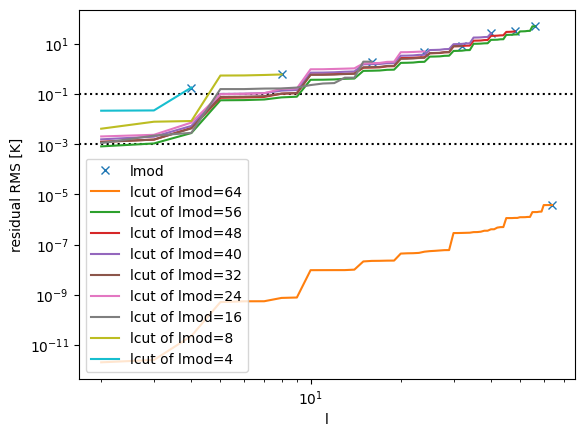

In [7]:
lmods = [4, 8, 16, 24, 32, 40, 48, 56, 64]
a_vectors = [np.load(f"saves/estimated_alm_lmod{lmod}.npy") for lmod in lmods]
rms_vals = [calc_rms(a_mod, a_fid, y_fid) for a_mod in a_vectors]

rms_vals_cutoffs = []
for a_mod, cutoff in zip(a_vectors, cutoffs):
    rms_vals_cutoffs.append([calc_rms(a_mod[:cut_index], a_fid=a_fid, y_mat=y_fid) for cut_index in cutoff])

plt.axhline(y=1e-1, linestyle=':', color='k')
plt.axhline(y=1e-3, linestyle=':', color='k')
plt.loglog(lmods, rms_vals, 'x', label='lmod')
to_loop = list(zip(rms_vals_cutoffs, cutoffs_l, lmods))
to_loop.reverse()
for rms, l, lmod in to_loop:
    plt.loglog(l, rms, label=f'lcut of lmod={lmod}')
plt.xlabel("l")
plt.ylabel("residual RMS [K]")
plt.legend()

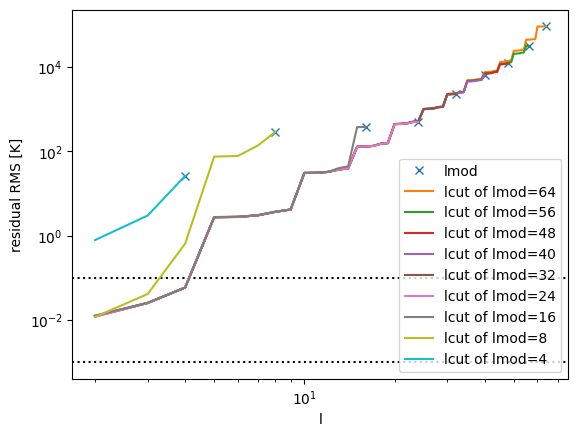

In [8]:
lmods = [4, 8, 16, 24, 32, 40, 48, 56, 64]
a_vectors = [np.load(f"saves/estimated_alm_lmod{lmod}_noise1e3.npy") for lmod in lmods]
rms_vals = [calc_rms(a_mod, a_fid, y_fid) for a_mod in a_vectors]

rms_vals_cutoffs = []
for a_mod, cutoff in zip(a_vectors, cutoffs):
    rms_vals_cutoffs.append([calc_rms(a_mod[:cut_index], a_fid=a_fid, y_mat=y_fid) for cut_index in cutoff])

plt.axhline(y=1e-1, linestyle=':', color='k')
plt.axhline(y=1e-3, linestyle=':', color='k')
plt.loglog(lmods, rms_vals, 'x', label='lmod')
to_loop = list(zip(rms_vals_cutoffs, cutoffs_l, lmods))
to_loop.reverse()
for rms, l, lmod in to_loop:
    plt.loglog(l, rms, label=f'lcut of lmod={lmod}')
plt.xlabel("l")
plt.ylabel("residual RMS [K]")
plt.legend()

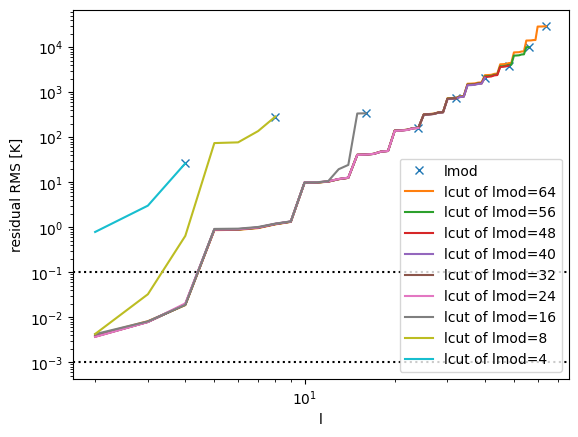

In [9]:
a_vectors = [np.load(f"saves/estimated_alm_lmod{lmod}_noise1e4.npy") for lmod in lmods]
rms_vals = [calc_rms(a_mod, a_fid, y_fid) for a_mod in a_vectors]

rms_vals_cutoffs = []
for a_mod, cutoff in zip(a_vectors, cutoffs):
    rms_vals_cutoffs.append([calc_rms(a_mod[:cut_index], a_fid=a_fid, y_mat=y_fid) for cut_index in cutoff])

plt.axhline(y=1e-1, linestyle=':', color='k')
plt.axhline(y=1e-3, linestyle=':', color='k')
plt.loglog(lmods, rms_vals, 'x', label='lmod')
to_loop = list(zip(rms_vals_cutoffs, cutoffs_l, lmods))
to_loop.reverse()
for rms, l, lmod in to_loop:
    plt.loglog(l, rms, label=f'lcut of lmod={lmod}')
plt.xlabel("l")
plt.ylabel("residual RMS [K]")
plt.legend()

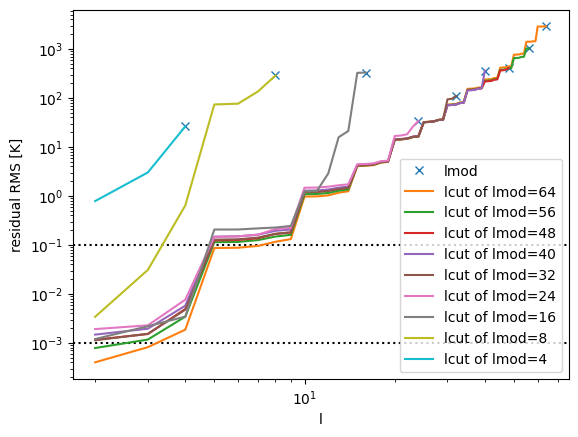

In [10]:
a_vectors = [np.load(f"saves/estimated_alm_lmod{lmod}_noise1e6.npy") for lmod in lmods]
rms_vals = [calc_rms(a_mod, a_fid, y_fid) for a_mod in a_vectors]

rms_vals_cutoffs = []
for a_mod, cutoff in zip(a_vectors, cutoffs):
    rms_vals_cutoffs.append([calc_rms(a_mod[:cut_index], a_fid=a_fid, y_mat=y_fid) for cut_index in cutoff])

plt.axhline(y=1e-1, linestyle=':', color='k')
plt.axhline(y=1e-3, linestyle=':', color='k')
plt.loglog(lmods, rms_vals, 'x', label='lmod')
to_loop = list(zip(rms_vals_cutoffs, cutoffs_l, lmods))
to_loop.reverse()
for rms, l, lmod in to_loop:
    plt.loglog(l, rms, label=f'lcut of lmod={lmod}')
plt.xlabel("l")
plt.ylabel("residual RMS [K]")
plt.legend()

In [11]:
d_noisy, noise_mat = SM.add_noise(d_fid, dnu=1, Ntau=npix, t_int=1e4)

Does this pattern hold if we increase the order of the foregrounds?